# 2010-2020 Nort Atlantic / Gulf Stream Argo sampling

https://github.com/orgs/euroargodev/projects/7#card-81467052

- Extract 2010-2020 real deployment plan
- Extract 2010-2020 area coming in floats
- Assemble 2010-2020 VirtualFleet deployment plan
- Compute effective 2010-2020 sampling

https://regionmask.readthedocs.io/en/stable/

In [1]:
import regionmask

import numpy as np
import pandas as pd
import xarray as xr
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import argopy
from argopy import IndexFetcher as ArgoIndexFetcher
from argopy.options import OPTIONS
argopy.set_options(local_ftp="/Volumes/CORIOLIS-GDAC")
argopy.status()

/Users/gmaze/miniconda3/envs/virtualfleet/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


HTML(value='<table><tr><td><img src="https://img.shields.io/static/v1?style=flat-square&label=src%20argovis%20…

In [2]:
argopy.clear_cache()

# Set-up

## Define regions

In [3]:
# Create the list of regionmask.Regions:

def rect_box(SW, NE):
    # SW: lon_south_west, lat_south_west
    # NE: lon_north_east, lat_north_east
    return [[SW[0],SW[1]],[NE[0],SW[1]],[NE[0],NE[1]],[SW[0],NE[1]]]

dict_regions = {
    # 'NATL_extended': {'box': [-95,-5.,10,70, '2010-01-01', '2020-01-01'], 'name': 'North Atlantic Extended'},
    # 'NATL': {'box': [-80,-10.,20,55, '2010-01-01', '2020-01-01'], 'name': 'North Atlantic Extended'},
    'NATL': {'box': [-80,-5.,15,65, '2010-01-01', '2020-01-01'], 'name': 'North Atlantic'},
    'GSE tight': {'box': [-75.,-48.,33,45.5, '2010-01-01', '2020-01-01'], 'name': 'Gulf Stream Extension'},
    # 'GSE': {'box': [-75.,-35.,35,50.], 'name': 'Gulf Stream Extension'},
}

boxes, numbers, names, abbrevs = [], [], [], []
for ii, r in enumerate(dict_regions.items()):
    numbers.append(ii)
    names.append(r[1]['name'])
    abbrevs.append(r[0])
    boxes.append(rect_box([r[1]['box'][0],r[1]['box'][2]],[r[1]['box'][1],r[1]['box'][3]]))
regions = regionmask.Regions(boxes, numbers, names, abbrevs, name='BCmask')
regions

<regionmask.Regions>
Name:     BCmask
overlap:  False

Regions:
0      NATL        North Atlantic
1 GSE tight Gulf Stream Extension

[2 regions]

<GeoAxesSubplot:>

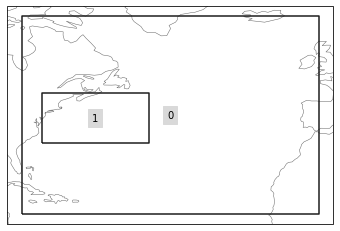

In [4]:
regions.plot()

## Load index for each regions

In [5]:
for r in regions:
    print(r.abbrev)
    index_box = dict_regions[r.abbrev]['box']
    # argo = ArgoIndexFetcher(src='gdac', ftp=OPTIONS['local_ftp'], cache=True).region(index_box)
    argo = ArgoIndexFetcher(src='gdac', cache=True).region(index_box)
    dict_regions[r.abbrev]['fetcher'] = argo
    dict_regions[r.abbrev]['index'] = argo.index
    # Add cycle number to each profiles:
    dict_regions[r.abbrev]['index']['cycle_number'] = dict_regions[r.abbrev]['index'].apply(lambda x: int("".join([c for c in x['file'].split("/")[-1].split("_")[-1].split(".nc")[0] if c.isdigit()])), axis=1)
    # Add profile direction:
    dict_regions[r.abbrev]['index']['direction'] = dict_regions[r.abbrev]['index'].apply(lambda x: 'D' if 'D' in x['file'].split("/")[-1].split("_")[-1].split(".nc")[0] else 'A', axis=1)

NATL
GSE tight


In [6]:
# ArgoIndexFetcher(src='gdac', cache=True).profile(6901283, 17).index

# Extract 2010-2020 Virtual Fleet deployment plan

For each float reporting a profile in the area, we trace trajectory upstream down to the lowest cycle number reported.

Those floats with a minimum cycle number of 0 or 1 have realy been deployed in the area.

Those floats with a minimum cycle number larger than 1 have been deployed elsewhere and entered the area to report at least one profile. 
But from the Virtual Fleet simulation point of view, these floats are deployed in the area and must accounted for.


In [7]:
# Get floats deployed inside the area:

df0 = dict_regions['NATL']['index'][dict_regions['NATL']['index']['cycle_number'] == 0].reset_index()
df0 = df0[df0['direction'] == 'A'].reset_index(drop=True)

df1 = dict_regions['NATL']['index'][dict_regions['NATL']['index']['cycle_number'] == 1].reset_index()
df1 = df1[df1['direction'] == 'A'].reset_index(drop=True)
unique_wmo0 = np.unique(df0['wmo'])
df1 = df1[df1.apply(lambda x: x['wmo'] not in unique_wmo0, axis=1)].reset_index(drop=True)

df2 = dict_regions['NATL']['index'][dict_regions['NATL']['index']['cycle_number'] == 2].reset_index()
df2 = df2[df2['direction'] == 'A'].reset_index(drop=True)
unique_wmo1 = np.unique(df1['wmo'])
df2 = df2[df2.apply(lambda x: x['wmo'] not in unique_wmo0 and x['wmo'] not in unique_wmo1, axis=1)].reset_index(drop=True)

dict_regions['NATL']['deployment_inside'] = pd.concat([df0, df1, df2]).sort_values(by='date').reset_index(drop=True)
dict_regions['NATL']['deployment_inside']

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,71820,bodc/6900656/profiles/D6900656_001.nc,2010-02-12 11:47:13,55.307,-15.886,A,846,BO,2019-09-12 21:32:40,6900656,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
1,71923,bodc/6900657/profiles/D6900657_001.nc,2010-02-14 02:02:55,53.579,-16.017,A,846,BO,2016-10-12 02:18:23,6900657,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
2,71682,bodc/6900655/profiles/D6900655_001.nc,2010-02-23 07:02:57,51.158,-12.241,A,846,BO,2016-10-12 01:46:13,6900655,"BODC, United Kingdom","Webb Research, Seabird sensor",1,A
3,155656,meds/4901139/profiles/D4901139_001.nc,2010-04-20 18:58:00,43.891,-57.824,A,846,ME,2017-02-28 16:28:53,4901139,"MEDS, Canada","Webb Research, Seabird sensor",1,A
4,156851,meds/4901155/profiles/R4901155_001.nc,2010-04-20 23:56:00,43.528,-57.508,A,846,ME,2018-02-20 14:53:43,4901155,"MEDS, Canada","Webb Research, Seabird sensor",1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,151440,coriolis/7900561/profiles/D7900561_001.nc,2019-12-01 10:18:02,17.796,-20.612,A,846,IF,2021-03-24 10:41:50,7900561,"Ifremer, France","Webb Research, Seabird sensor",1,A
1082,151420,coriolis/7900560/profiles/D7900560_001.nc,2019-12-01 10:58:14,17.790,-20.610,A,846,IF,2021-02-19 14:08:07,7900560,"Ifremer, France","Webb Research, Seabird sensor",1,A
1083,167171,meds/4902498/profiles/D4902498_001.nc,2019-12-02 04:55:00,42.210,-48.366,A,844,ME,2021-11-19 15:43:31,4902498,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
1084,167174,meds/4902499/profiles/D4902499_001.nc,2019-12-02 04:55:00,42.173,-48.324,A,844,ME,2021-11-16 19:47:11,4902499,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A


In [8]:
# Get floats deployed outside the area but reporting at least one profile:

df =  dict_regions['NATL']['index'].groupby('wmo').min().reset_index(drop=False)
unique_wmo = np.unique(dict_regions['NATL']['deployment_inside']['wmo'])
df = df[df.apply(lambda x: x['wmo'] not in unique_wmo, axis=1)].reset_index(drop=True)

# df = df[['date', 'latitude', 'longitude', 'wmo', 'cycle_number', 'institution_code', 'file', 'direction']].sort_values(by='date')
dict_regions['NATL']['deployment_outside'] = df.sort_values(by='date').reset_index(drop=True)
dict_regions['NATL']['deployment_outside']

,wmo,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,institution,profiler,cycle_number,direction
0,6900243,coriolis/6900243/profiles/D6900243_134.nc,2010-01-01 02:30:49,28.796,-25.531,A,846,IF,2019-06-03 20:00:11,"Ifremer, France","Webb Research, Seabird sensor",134,A
1,4901132,meds/4901132/profiles/D4901132_018.nc,2010-01-01 03:48:00,40.844,-37.507,A,846,ME,2019-01-29 16:00:22,"MEDS, Canada","Webb Research, Seabird sensor",18,A
2,6900387,bodc/6900387/profiles/D6900387_156.nc,2010-01-01 04:01:02,55.650,-21.083,A,846,BO,2017-02-01 20:03:40,"BODC, United Kingdom","Webb Research, Seabird sensor",156,A
3,6900493,coriolis/6900493/profiles/D6900493_056.nc,2010-01-01 04:25:00,42.221,-24.071,A,841,IF,2015-10-22 10:43:06,"Ifremer, France","Provor, Seabird conductivity sensor",56,A
4,6900630,coriolis/6900630/profiles/D6900630_097.nc,2010-01-01 04:38:00,18.015,-28.887,A,841,IF,2020-08-19 16:54:20,"Ifremer, France","Provor, Seabird conductivity sensor",97,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,1901712,aoml/1901712/profiles/D1901712_200.nc,2019-06-24 14:25:16,15.073,-21.794,A,854,AO,2022-02-18 15:31:31,"AOML, USA",S2A float,200,A
462,6902837,coriolis/6902837/profiles/D6902837_024.nc,2019-08-29 06:50:00,15.103,-24.936,A,844,IF,2021-07-08 12:23:58,"Ifremer, France","Arvor, Seabird conductivity sensor",24,A
463,4901483,aoml/4901483/profiles/D4901483_227.nc,2019-10-30 03:21:31,15.038,-54.196,A,854,AO,2022-03-14 12:54:56,"AOML, USA",S2A float,227,A
464,3901850,coriolis/3901850/profiles/D3901850_127.nc,2019-12-07 11:54:30,63.916,-6.868,A,844,IF,2021-10-22 12:49:32,"Ifremer, France","Arvor, Seabird conductivity sensor",127,A


In [9]:
# Further decomposition
first_month = np.logical_and(dict_regions['NATL']['deployment_outside']['date'].dt.year == 2010, dict_regions['NATL']['deployment_outside']['date'].dt.month == 1)
dict_regions['NATL']['deployment_outside_first'] = dict_regions['NATL']['deployment_outside'][first_month]
dict_regions['NATL']['deployment_outside_else'] = dict_regions['NATL']['deployment_outside'][~first_month]

In [28]:
# dict_regions['NATL']['deployment_outside_else'].sort_values(by='cycle_number')

In [27]:
# dict_regions['NATL']['deployment_outside_else'].groupby('cycle_number').count()

In [12]:
dict_regions['NATL']['deployment'] = pd.concat([dict_regions['NATL']['deployment_inside'], 
                                                dict_regions['NATL']['deployment_outside']]).sort_values(by='date').reset_index(drop=True)
dict_regions['NATL']['deployment']

,index,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler,cycle_number,direction
0,NaN,coriolis/6900243/profiles/D6900243_134.nc,2010-01-01 02:30:49,28.796,-25.531,A,846,IF,2019-06-03 20:00:11,6900243,"Ifremer, France","Webb Research, Seabird sensor",134,A
1,NaN,meds/4901132/profiles/D4901132_018.nc,2010-01-01 03:48:00,40.844,-37.507,A,846,ME,2019-01-29 16:00:22,4901132,"MEDS, Canada","Webb Research, Seabird sensor",18,A
2,NaN,bodc/6900387/profiles/D6900387_156.nc,2010-01-01 04:01:02,55.650,-21.083,A,846,BO,2017-02-01 20:03:40,6900387,"BODC, United Kingdom","Webb Research, Seabird sensor",156,A
3,NaN,coriolis/6900493/profiles/D6900493_056.nc,2010-01-01 04:25:00,42.221,-24.071,A,841,IF,2015-10-22 10:43:06,6900493,"Ifremer, France","Provor, Seabird conductivity sensor",56,A
4,NaN,coriolis/6900630/profiles/D6900630_097.nc,2010-01-01 04:38:00,18.015,-28.887,A,841,IF,2020-08-19 16:54:20,6900630,"Ifremer, France","Provor, Seabird conductivity sensor",97,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,167174.0,meds/4902499/profiles/D4902499_001.nc,2019-12-02 04:55:00,42.173,-48.324,A,844,ME,2021-11-16 19:47:11,4902499,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
1548,167171.0,meds/4902498/profiles/D4902498_001.nc,2019-12-02 04:55:00,42.210,-48.366,A,844,ME,2021-11-19 15:43:31,4902498,"MEDS, Canada","Arvor, Seabird conductivity sensor",1,A
1549,NaN,coriolis/3901850/profiles/D3901850_127.nc,2019-12-07 11:54:30,63.916,-6.868,A,844,IF,2021-10-22 12:49:32,3901850,"Ifremer, France","Arvor, Seabird conductivity sensor",127,A
1550,151409.0,coriolis/7900545/profiles/D7900545_001.nc,2019-12-10 06:00:00,17.575,-24.364,A,844,IF,2021-03-16 10:29:01,7900545,"Ifremer, France","Arvor, Seabird conductivity sensor",1,A


,date,latitude,longitude,wmo,cycle_number,institution_code,file
0,2010-01-01 02:30:49,28.796,-25.531,6900243,134,IF,coriolis/6900243/profiles/D6900243_134.nc
1,2010-01-01 03:48:00,40.844,-37.507,4901132,18,ME,meds/4901132/profiles/D4901132_018.nc
2,2010-01-01 04:01:02,55.650,-21.083,6900387,156,BO,bodc/6900387/profiles/D6900387_156.nc
3,2010-01-01 04:25:00,42.221,-24.071,6900493,56,IF,coriolis/6900493/profiles/D6900493_056.nc
4,2010-01-01 04:38:00,18.015,-28.887,6900630,97,IF,coriolis/6900630/profiles/D6900630_097.nc
...,...,...,...,...,...,...,...
1547,2019-12-02 04:55:00,42.173,-48.324,4902499,1,ME,meds/4902499/profiles/D4902499_001.nc
1548,2019-12-02 04:55:00,42.210,-48.366,4902498,1,ME,meds/4902498/profiles/D4902498_001.nc
1549,2019-12-07 11:54:30,63.916,-6.868,3901850,127,IF,coriolis/3901850/profiles/D3901850_127.nc
1550,2019-12-10 06:00:00,17.575,-24.364,7900545,1,IF,coriolis/7900545/profiles/D7900545_001.nc


In [13]:
Nt = len(np.unique(dict_regions['NATL']['deployment']['wmo']))
Ni = len(np.unique(dict_regions['NATL']['deployment_inside']['wmo']))
No = len(np.unique(dict_regions['NATL']['deployment_outside']['wmo']))
assert Nt == (Ni + No)
assert No == len(list(set(np.unique(dict_regions['NATL']['deployment_outside']['wmo'])) - set(np.unique(dict_regions['NATL']['deployment_inside']['wmo'])) ))

## Analyse the deployment plan

In [14]:
unique_wmo = np.unique(dict_regions['NATL']['deployment']['wmo'])
Nt = len(unique_wmo)

df0 = dict_regions['NATL']['deployment'][dict_regions['NATL']['deployment']['cycle_number'] == 0].reset_index()
unique_wmo0 = np.unique(df0['wmo'])

df1 = dict_regions['NATL']['deployment'][dict_regions['NATL']['deployment']['cycle_number'] == 1].reset_index()
df1 = df1[df1.apply(lambda x: x['wmo'] not in unique_wmo0, axis=1)].reset_index(drop=True)
unique_wmo1 = np.unique(df1['wmo'])

dict_regions['NATL']['deployment_inside'] = pd.concat([df0, df1]).sort_values(by='date').reset_index(drop=True)

dfN = dict_regions['NATL']['deployment'][dict_regions['NATL']['deployment']['cycle_number'] > 1].reset_index()
dfN = dfN[dfN.apply(lambda x: x['wmo'] not in unique_wmo0, axis=1)].reset_index(drop=True)
dfN = dfN[dfN.apply(lambda x: x['wmo'] not in unique_wmo1, axis=1)].reset_index(drop=True)
unique_wmoN = np.unique(dfN['wmo'])
dict_regions['NATL']['deployment_outside'] = dfN.sort_values(by='date').reset_index(drop=True)

Nt = len(np.unique(dict_regions['NATL']['deployment']['wmo']))
Nd = len(unique_wmo0) + len(unique_wmo1)
Ni = len(unique_wmoN)
print("%i floats reporting any cycle in the area" % Nt)
print("%i floats (%0.1f %%) deployed in the area and time period (reporting cycle #0 or #1)" % (Nd, Nd*100/Nt))
print("%i floats (%0.1f %%) NOT deployed in the area OR time period (but reporting cycle > #1)" % (Ni, Ni*100/Nt))
# print("%i floats certainly deployed in the area  and time period (reporting cycle #1)" % len(unique_wmo1))
# print("%i floats assumed to be deployed in the area and time period (%0.1f %%)" % (Nd, Nd*100/Nt))
# print("%i floats NOT deployed in the area OR during the time period (%0.1f %%)" % (Nt - Nd, 100-Nd*100/Nt))

1552 floats reporting any cycle in the area
1063 floats (68.5 %) deployed in the area and time period (reporting cycle #0 or #1)
489 floats (31.5 %) NOT deployed in the area OR time period (but reporting cycle > #1)


In [15]:
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=10,
)
subplot_kw={'projection': argopy.plot.utils.cartopy.crs.PlateCarree(), 'extent': np.array([-85,5.,10,60]) + np.array([-0.1,+0.1,-0.1,+0.1])}

In [16]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
# regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
# dict_regions['NATL']['deployment_inside'].plot(kind='scatter', x="longitude", y="latitude", c='cycle_number', ax=ax, marker='.')
# argopy.plot.utils.latlongrid(ax)
# ax.set_title('2010-2020 Argo floats deployment locations')
# plt.savefig('2010-2010-Deployment-Locations.png', bbox_inches='tight', pad_inches=0.1)

In [17]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
# regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
# dict_regions['NATL']['deployment_outside'].plot(kind='scatter', x="longitude", y="latitude", c='cycle_number', ax=ax, marker='.')
# argopy.plot.utils.latlongrid(ax)
# # ax.set_title('2010-2020 Argo floats deployment locations')
# # plt.savefig('2010-2010-Deployment-Locations.png', bbox_inches='tight', pad_inches=0.1)

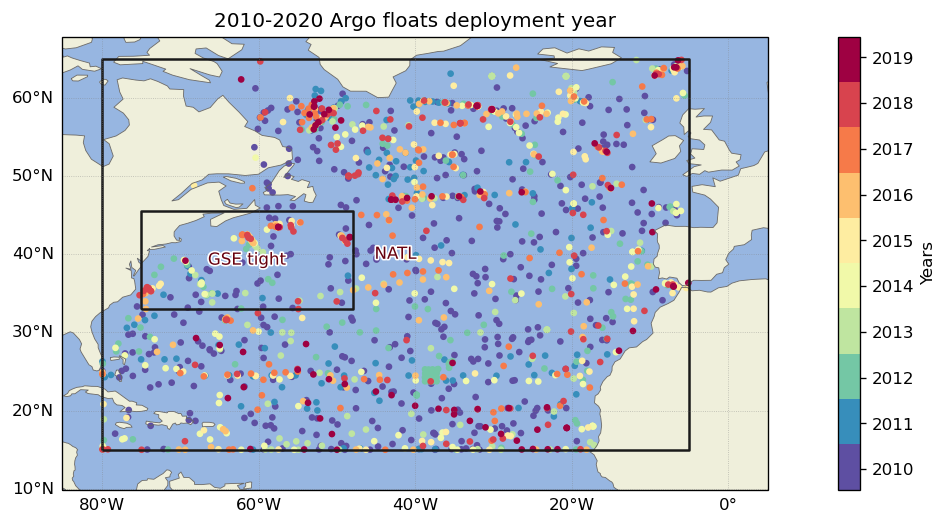

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)

census = dict_regions['NATL']['deployment'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
sc = ax.scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')

argopy.plot.utils.latlongrid(ax)
ax.set_title('2010-2020 Argo floats deployment year');
plt.savefig('2010-2010-Deployment-LocationYear.png', bbox_inches='tight', pad_inches=0.1)

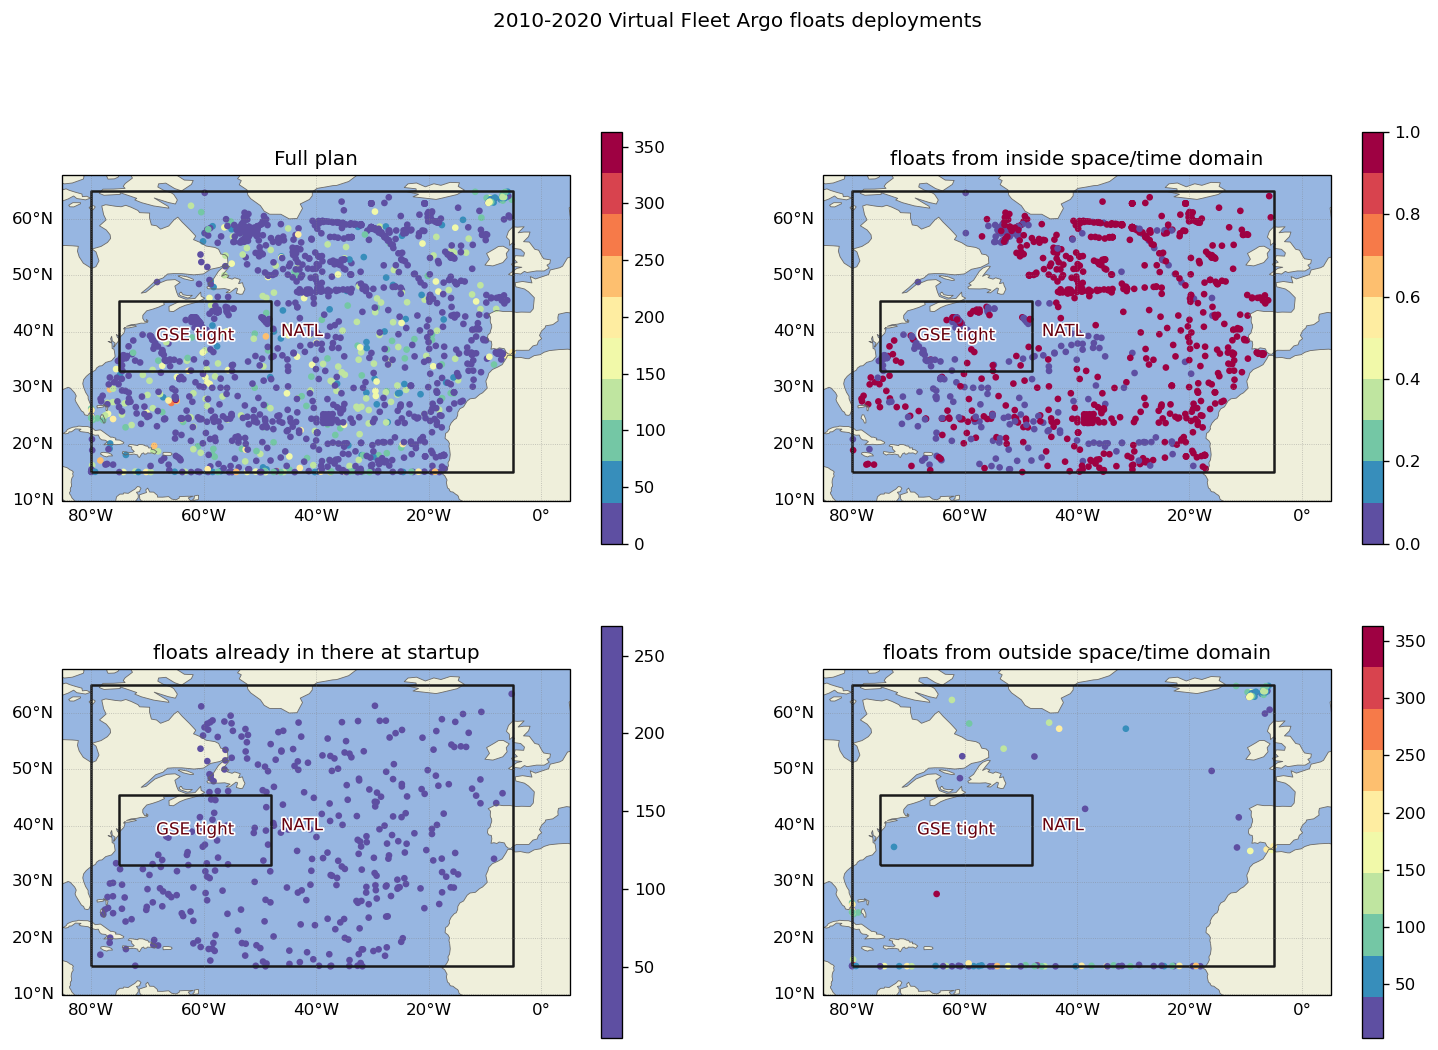

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
ax = ax.flatten()

ii = 0
regions.plot(ax=ax[ii], add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)

census = dict_regions['NATL']['deployment'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
# sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census["cycle_number"], marker='.', cmap=dc.cmap)
# dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')
plt.colorbar(sc, ax=ax[ii])

argopy.plot.utils.latlongrid(ax[ii])
ax[ii].set_title('Full plan');

ii+=1
regions.plot(ax=ax[ii], add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)

census = dict_regions['NATL']['deployment_inside'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
# sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census["cycle_number"], marker='.', cmap=dc.cmap)
# dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')
plt.colorbar(sc, ax=ax[ii])

argopy.plot.utils.latlongrid(ax[ii])
ax[ii].set_title('floats from inside space/time domain');

ii+=1
regions.plot(ax=ax[ii], add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)

census = dict_regions['NATL']['deployment_outside_first'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
# sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census["cycle_number"], marker='.', cmap=dc.cmap)
# dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')
# dc.cbar(ticklabels=np.unique(census["cycle_number"]), fraction=0.03, label='CYC')
plt.colorbar(sc, ax=ax[ii])

argopy.plot.utils.latlongrid(ax[ii])
ax[ii].set_title('floats already in there at startup');

ii+=1
regions.plot(ax=ax[ii], add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)

census = dict_regions['NATL']['deployment_outside_else'].set_index('date')
dc = argopy.plot.utils.discrete_coloring(name='Spectral_r', N=len(np.unique(census.index.year)))
# sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census.index.year, marker='.', cmap=dc.cmap)
sc = ax[ii].scatter(x=census['longitude'], y=census["latitude"], c=census["cycle_number"], marker='.', cmap=dc.cmap)
# dc.cbar(ticklabels=np.unique(census.index.year), fraction=0.03, label='Years')
# dc.cbar(ticklabels=np.unique(census["cycle_number"]), fraction=0.03, label='CYC')
plt.colorbar(sc, ax=ax[ii])

argopy.plot.utils.latlongrid(ax[ii])
ax[ii].set_title('floats from outside space/time domain');

fig.suptitle('2010-2020 Virtual Fleet Argo floats deployments')
plt.savefig('2010-2010-Deployment-Decomposed.png', bbox_inches='tight', pad_inches=0.1)

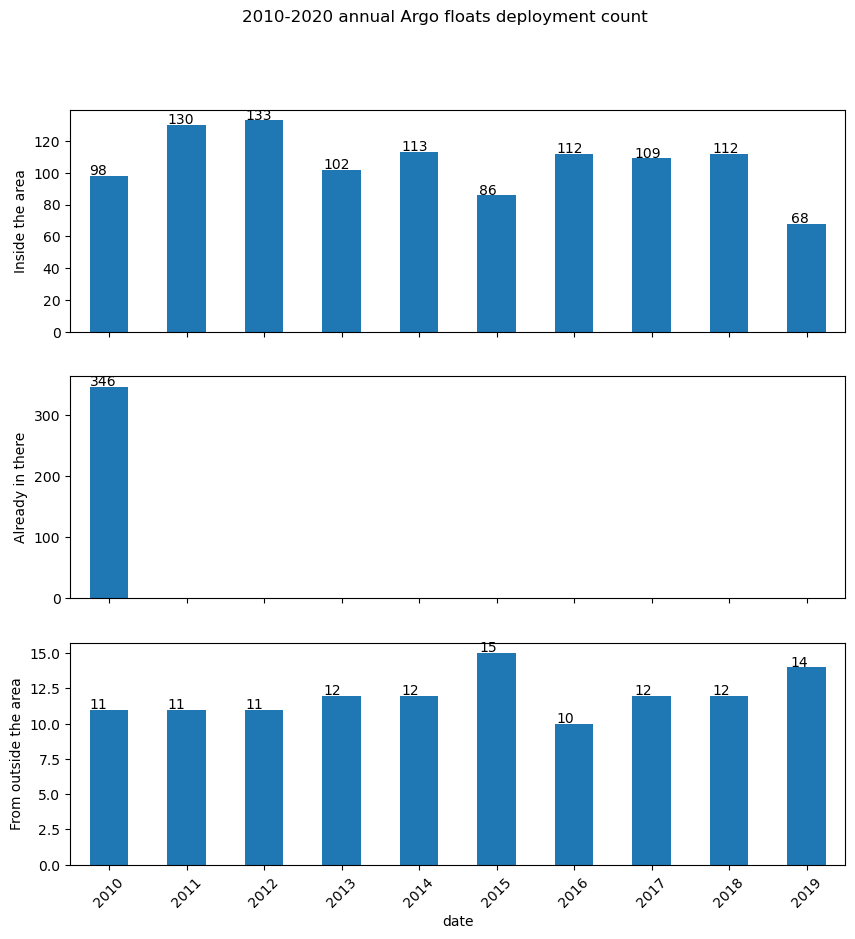

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), dpi=100, facecolor='w', edgecolor='k', sharex=True)

census = dict_regions['NATL']['deployment_inside'].set_index('date').groupby(pd.Grouper(freq='Y'))['wmo'].count()
census.plot.bar(ax=ax[0])
[ax[0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax[0].patches] 
ax[0].set_xticklabels(census.index.year, rotation = 45)
ax[0].set_ylabel('Inside the area')
# ax[0].set_title('2010-2020 annual Argo floats deployment count')

census = dict_regions['NATL']['deployment_outside_first'].set_index('date').groupby(pd.Grouper(freq='Y'))['wmo'].count()
census.plot.bar(ax=ax[1])
[ax[1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax[1].patches] 
ax[1].set_xticklabels(census.index.year, rotation = 45)
ax[1].set_ylabel('Already in there')
# ax[1].set_title('2010-2020 annual Argo floats deployment count')

census = dict_regions['NATL']['deployment_outside_else'].set_index('date').groupby(pd.Grouper(freq='Y'))['wmo'].count()
census.plot.bar(ax=ax[2])
[ax[2].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax[2].patches] 
ax[2].set_xticklabels(census.index.year, rotation = 45)
ax[2].set_ylabel('From outside the area')
# ax[1].set_title('2010-2020 annual Argo floats deployment count')

fig.suptitle('2010-2020 annual Argo floats deployment count')
plt.savefig('2010-2010-Deployment-Year.png', bbox_inches='tight', pad_inches=0.1)

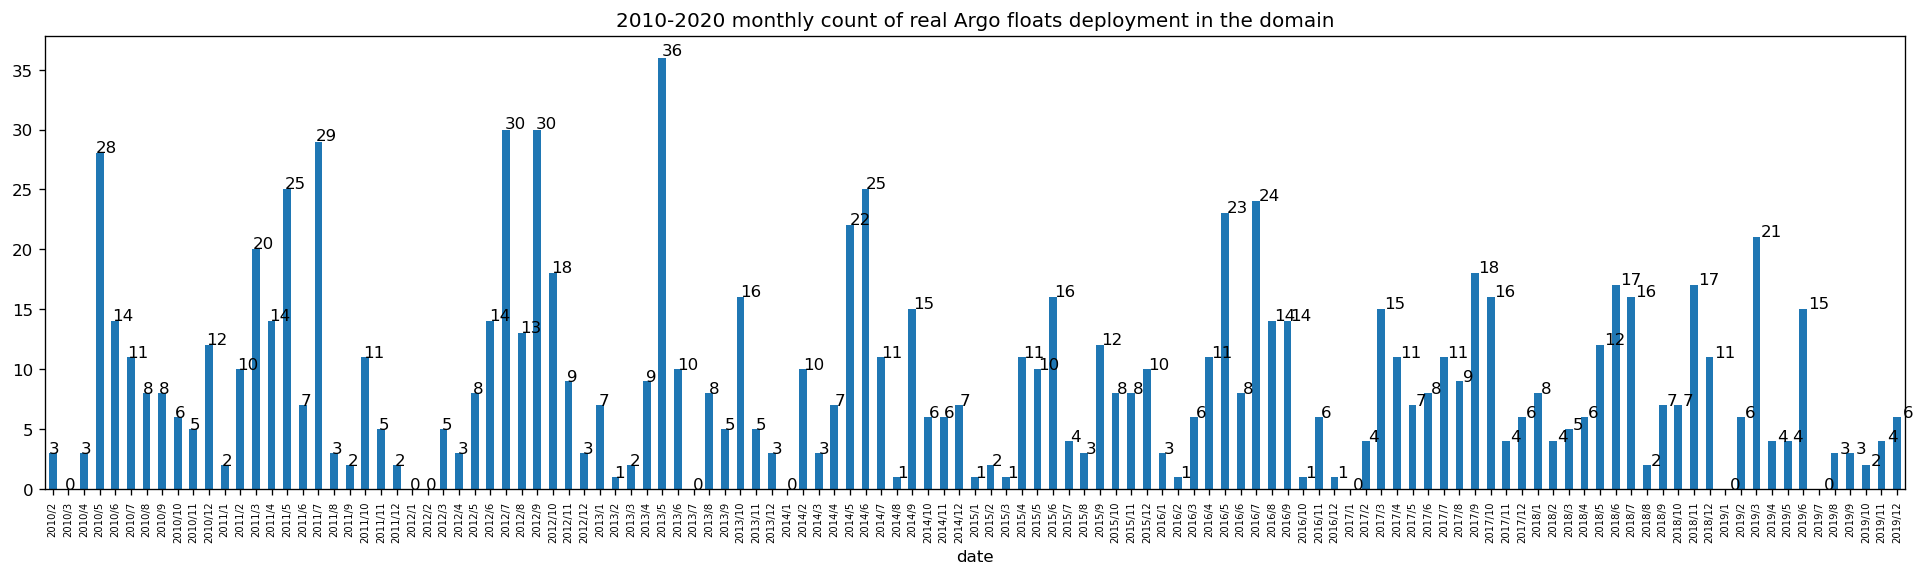

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5), dpi=120, facecolor='w', edgecolor='k')
census = dict_regions['NATL']['deployment_inside'].set_index('date').groupby(pd.Grouper(freq='M'))['wmo'].count()
census.plot.bar(ax=ax)
[ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) for p in ax.patches] 
ax.set_xticklabels(["%i/%i" % (i.year, i.month) for i in census.index], rotation = 90, fontsize=6)
ax.set_title('2010-2020 monthly count of real Argo floats deployment in the domain');
plt.savefig('2010-2010-Real-Deployment-Month.png', bbox_inches='tight', pad_inches=0.1)

## Save for later re-use with VirtualFleet

What we need here is simply a list of latitude/longitude/date.  
So we just save the deployment pandas index into a json file, easy to read from anything.    
It will be easy to load it and extract latitude/longitude/date.  


In [33]:
out_file = '2010-2020-Deployment-Plan.json'
dict_regions['NATL']['deployment'][['date', 'latitude', 'longitude', 'wmo', 'cycle_number', 'institution_code', 'file']].to_json(out_file, orient='records')

In [34]:
pd.read_json(out_file, orient='records')

,date,latitude,longitude,wmo,cycle_number,institution_code,file
0,2010-01-01 02:30:49,28.796,-25.531,6900243,134,IF,coriolis/6900243/profiles/D6900243_134.nc
1,2010-01-01 03:48:00,40.844,-37.507,4901132,18,ME,meds/4901132/profiles/D4901132_018.nc
2,2010-01-01 04:01:02,55.650,-21.083,6900387,156,BO,bodc/6900387/profiles/D6900387_156.nc
3,2010-01-01 04:25:00,42.221,-24.071,6900493,56,IF,coriolis/6900493/profiles/D6900493_056.nc
4,2010-01-01 04:38:00,18.015,-28.887,6900630,97,IF,coriolis/6900630/profiles/D6900630_097.nc
...,...,...,...,...,...,...,...
1547,2019-12-02 04:55:00,42.173,-48.324,4902499,1,ME,meds/4902499/profiles/D4902499_001.nc
1548,2019-12-02 04:55:00,42.210,-48.366,4902498,1,ME,meds/4902498/profiles/D4902498_001.nc
1549,2019-12-07 11:54:30,63.916,-6.868,3901850,127,IF,coriolis/3901850/profiles/D3901850_127.nc
1550,2019-12-10 06:00:00,17.575,-24.364,7900545,1,IF,coriolis/7900545/profiles/D7900545_001.nc


# Compute effective 2010-2020 sampling

This is what we expect to reproduce for validation of the simulation and then to modify to improve BC sampling


In [24]:
# Compute profile density on a 1x1 degree grid:
ds = dict_regions['NATL']['index'].to_xarray()
xbins = np.arange(-90,10)
ybins = np.arange(10,70)
obs = histogram(ds['longitude'], ds['latitude'], bins=[xbins, ybins])
obs = obs.where(obs>0, other=np.NaN)

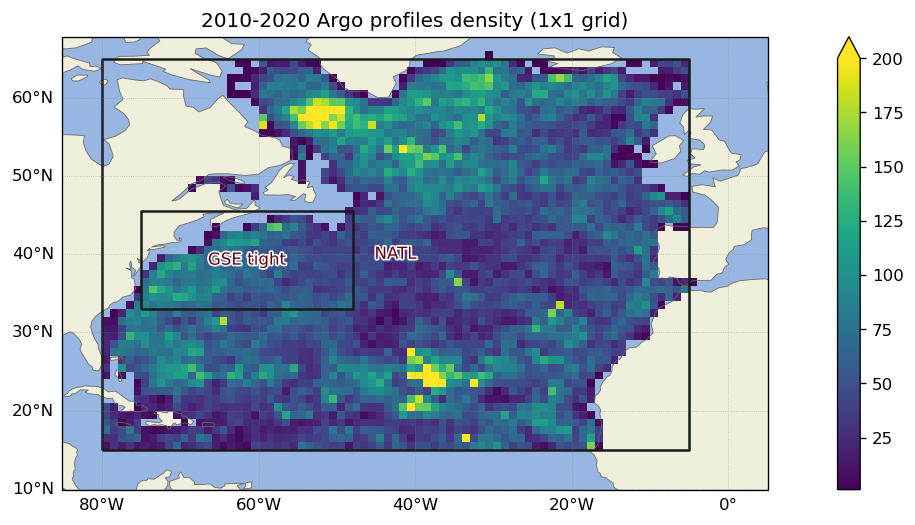

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
regions.plot(ax=ax, add_land=True, add_ocean=True, label="abbrev", text_kws=text_kws)
argopy.plot.utils.latlongrid(ax)
cl = obs.plot(x='longitude_bin', vmin=1, vmax=200, add_colorbar=0)
plt.colorbar(cl, ax=ax, extend='max')
ax.set_title('2010-2020 Argo profiles density (1x1 grid)')
plt.savefig('2010-2010-Profile-Density.png', bbox_inches='tight', pad_inches=0.1)

In [26]:
ds.groupby('date.season').count()['file']

<xarray.DataArray 'file' (season: 4)>
array([39670, 42714, 41352, 43441])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'